# OFFICIAL IMPLEMENTATION OF HRP OPTIMIZATION BASED ON MARCOS LOPEZ DE PRADO (2016) AND ERNEST CHAN TASK (2025)

In [168]:
import pandas_datareader.data as web
from datetime import date, timedelta
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from pypfopt.hierarchical_portfolio import HRPOpt
from scipy.spatial.distance import pdist

In [169]:

tickers = ["F", "GM", "TSLA","BAC", "JPM"]
end   = date.today()
start = end - timedelta(days=5*365)

df = (
    web.DataReader(tickers, "stooq", start, end)      # reshuffle multi-index to match yfinance layout
    .sort_index()
)
df

Attributes     Close                                            High           \
Symbols            F       GM      TSLA      BAC       JPM         F       GM   
Date                                                                            
2020-06-29   5.22467  25.1864   67.2900  22.1328   86.2977   5.27683  25.2362   
2020-06-30   5.28551  25.1864   71.9867  22.4736   87.2792   5.30291  25.4800   
2020-07-01   5.19859  24.8478   74.6433  22.0100   86.5375   5.37239  25.8185   
2020-07-02   5.25941  25.1266   80.5767  22.0376   86.8184   5.36372  25.7339   
2020-07-06   5.38113  25.6144   91.4400  22.3891   89.0122   5.38972  25.9231   
...              ...      ...       ...      ...       ...       ...      ...   
2025-06-18  10.43000  48.0900  322.0500  45.0600  273.9600  10.53000  48.7000   
2025-06-20  10.59000  48.2000  322.1600  45.5000  275.0000  10.60000  48.7350   
2025-06-23  10.75000  48.5200  348.6800  46.3000  278.2700  10.75000  48.5800   
2025-06-24  10.73000  49.0000  340.4700  46.6600  281.2600  10.87000  49.3650   
2025-06-25  10.48000  48.1300  327.5500  46.8500  284.0600  10.76500  49.0999   

Attributes                               ...      Open                     \
Symbols         TSLA      BAC       JPM  ...         F       GM      TSLA   
Date                                     ...                                
2020-06-29   67.3333  22.5541   87.6790  ...   5.13768  24.5990   64.6000   
2020-06-30   72.5133  22.6259   87.8362  ...   5.19859  24.9773   67.1000   
2020-07-01   75.6900  22.7770   88.8069  ...   5.30291  25.1864   72.2000   
2020-07-02   81.8667  22.6995   88.9739  ...   5.30291  25.5049   81.4333   
2020-07-06   91.8533  22.7869   89.2008  ...   5.33766  25.8434   85.1133   
...              ...      ...       ...  ...       ...      ...       ...   
2025-06-18  329.3200  45.2000  277.7200  ...  10.43000  48.3000  317.3100   
2025-06-20  332.3600  45.6500  277.3000  ...  10.49000  48.4000  327.9500   
2025-06-23  357.5400  46.3700  278.5500  ...  10.55000  47.9600  327.5400   
2025-06-24  356.2600  47.1900  282.7150  ...  10.79000  48.9600  356.1700   
2025-06-25  343.0000  46.9800  284.2800  ...  10.76000  49.0050  342.7000   

Attributes                           Volume                             \
Symbols         BAC       JPM             F            GM         TSLA   
Date                                                                     
2020-06-29  22.1525   86.6681  6.695807e+07  1.005687e+07  135396060.0   
2020-06-30  21.9532   86.1395  7.121523e+07  1.438659e+07  253777515.0   
2020-07-01  22.7388   88.0504  7.184261e+07  1.201701e+07  199903440.0   
2020-07-02  22.5590   88.7666  7.738231e+07  2.230244e+07  258751725.0   
2020-07-06  22.5394   88.4768  7.353022e+07  9.213525e+06  308547960.0   
...             ...       ...           ...           ...          ...   
2025-06-18  44.2600  269.8000  8.277017e+07  8.418081e+06   95137686.0   
2025-06-20  45.3050  275.5300  1.167434e+08  2.224984e+07  108688008.0   
2025-06-23  45.4250  275.3950  7.757651e+07  1.062648e+07  190716815.0   
2025-06-24  46.7400  280.2100  7.724441e+07  1.255043e+07  114736245.0   
2025-06-25  46.5750  281.2550  9.192733e+07  6.906761e+06  119845050.0   

Attributes                              
Symbols              BAC           JPM  
Date                                    
2020-06-29  7.003299e+07  1.993681e+07  
2020-06-30  6.522133e+07  2.062359e+07  
2020-07-01  6.063881e+07  2.021268e+07  
2020-07-02  5.918068e+07  2.971908e+07  
2020-07-06  6.297340e+07  1.987839e+07  
...                  ...           ...  
2025-06-18  3.768473e+07  9.586440e+06  
2025-06-20  6.459157e+07  1.396967e+07  
2025-06-23  4.268362e+07  8.094559e+06  
2025-06-24  4.543759e+07  9.267941e+06  
2025-06-25  3.353239e+07  6.826901e+06  

[1254 rows x 25 columns]

In [170]:
close = (
    df["Close"]          # first level = 'Close'
      .replace(0, np.nan)  # Stooq occasionally stores 0 instead of NaN
      .ffill()             # forward-fill any start-of-series NaNs
)
close.index = pd.to_datetime(close.index)   # ensure DateTime index
close.tail()


Symbols,F,GM,TSLA,BAC,JPM
Date,,,,,
2025-06-18,10.43,48.09,322.05,45.06,273.96
2025-06-20,10.59,48.20,322.16,45.50,275.00
2025-06-23,10.75,48.52,348.68,46.30,278.27
2025-06-24,10.73,49.00,340.47,46.66,281.26
2025-06-25,10.48,48.13,327.55,46.85,284.06


In [171]:
returns = close.pct_change().dropna(how="all")
returns.describe().T


,count,mean,std,min,25%,50%,75%,max
Symbols,,,,,,,,
F,1253.0,0.000874,0.025162,-0.183616,-0.013477,0.000788,0.014562,0.116644
GM,1253.0,0.000800,0.023835,-0.089867,-0.013109,0.000895,0.013987,0.098099
TSLA,1253.0,0.002081,0.040562,-0.210628,-0.020632,0.001536,0.022558,0.226900
BAC,1253.0,0.000762,0.018118,-0.110633,-0.009565,0.000352,0.010634,0.141936
JPM,1253.0,0.001083,0.016270,-0.080502,-0.007699,0.001005,0.009689,0.135472


Step 1 – hierarchical-cluster the assets


In [172]:
def cluster_assets(returns, k=None, linkage_method="single"):
    """
    Hierarchical clustering on the 'distance–of–distances' matrix.

    returns         : DataFrame of asset returns (T × N)
    k               : # clusters. If None, auto-select by max linkage gap.
    linkage_method  : linkage to use (e.g. "single", "complete", "average", etc.)
    """
    # 1. Correlation → distance matrix
    corr = returns.corr()
    dist = np.sqrt(0.5 * (1 - corr))

    # 2. Distance-of-distances: treat each column of 'dist' as a vector
    #    and compute Euclidean pdist on those N vectors
    dd = pdist(dist.values, metric="euclidean")  # condensed 1D array

    # 3. Hierarchical clustering on dd
    Z = linkage(dd, method=linkage_method)

    # 4. Auto-pick k if not provided
    if k is None:
        # look for the largest jump in linkage heights
        gaps = np.diff(Z[:, 2])
        k = gaps.argmax() + 2

    # 5. Flat cluster assignment (0-based labels)
    labels = fcluster(Z, k, criterion="maxclust") - 1

    return pd.Series(labels, index=returns.columns), Z

In [173]:
labels, Z = cluster_assets(returns, k=None)   # let the heuristic decide
labels


Symbols
F       1
GM      1
TSLA    2
BAC     0
JPM     0
dtype: int32

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [20.0, 20.0, 40.0, 40.0],
  [5.0, 5.0, 30.0, 30.0]],
 'dcoord': [[0.0, 0.39981945698272486, 0.39981945698272486, 0.0],
  [0.0, 0.48446054710077624, 0.48446054710077624, 0.0],
  [0.39981945698272486,
   0.7363857772378637,
   0.7363857772378637,
   0.48446054710077624],
  [0.0, 0.8788102348986664, 0.8788102348986664, 0.7363857772378637]],
 'ivl': ['TSLA', 'BAC', 'JPM', 'F', 'GM'],
 'leaves': [2, 3, 4, 0, 1],
 'color_list': ['C1', 'C2', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C2', 'C2']}

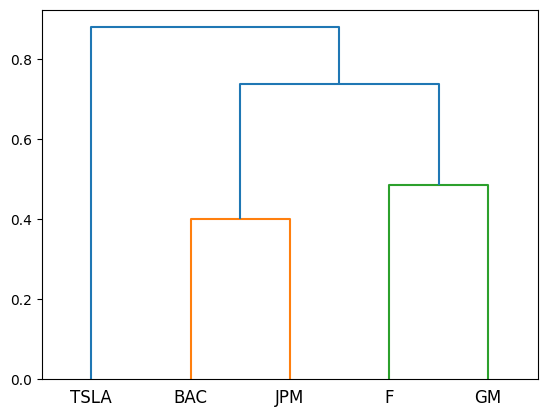

In [174]:
dendrogram(Z, labels=returns.columns, leaf_rotation=0)


In [177]:
# step2 
def intra_cluster_risk_parity(returns, labels):
    """
    For every cluster c:
      • if it has >1 assets → run HRP on that sub-universe
      • if it has exactly 1 asset → weight = 1.0
    Result: a Series indexed by ticker whose weights sum to 1 *inside* each cluster.
    """
    w_intra = {}

    for c in sorted(labels.unique()):
        assets = labels[labels == c].index.tolist()

        if len(assets) == 1:
            # 1-asset cluster → risk-parity is trivially all-in on that asset
            w_intra[assets[0]] = 1.0
            continue

        hrp_c = HRPOpt(returns[assets])          # ≥2 assets, safe
        w_c   = hrp_c.optimize()
        w_intra.update(w_c)                      # merge dicts

    # convert to Series, sort for readability
    return pd.Series(w_intra).sort_index()


In [178]:
w_intra = intra_cluster_risk_parity(returns, labels)
w_intra.groupby(labels).sum()    # sanity-check → every cluster sums to 1
w_intra

BAC     0.446413
F       0.472946
GM      0.527054
JPM     0.553587
TSLA    1.000000
dtype: float64

In [179]:
# Step3 allocate capital across clusters

In [180]:
def kelly_across_clusters(returns, labels, w_intra):
    clusters = labels.unique()

    # build cluster-level return series
    cluster_r = pd.DataFrame(index=returns.index, columns=clusters, dtype=float)
    for c in clusters:
        assets = labels[labels == c].index
        cluster_r[c] = returns[assets] @ w_intra.loc[assets]

    mu = cluster_r.mean() * 252
    sig = cluster_r.std(ddof=0) * np.sqrt(252)

    W_raw = (mu / sig**2).clip(lower=0)   # non-negative Kelly fraction
    return W_raw / W_raw.sum()            # normalise to ΣW(c)=1


In [181]:
W_clusters = kelly_across_clusters(returns, labels, w_intra)
print("Capital weights across clusters:")
display(W_clusters.round(4))


Capital weights across clusters:


1    0.2493
2    0.1996
0    0.5511
dtype: float64

In [182]:
def final_asset_weights(w_intra, W_clusters, labels):
    w_final = w_intra.copy()
    for c, Wc in W_clusters.items():
        w_final.loc[labels == c] *= Wc
    return w_final / w_final.sum()        # guarantee Σω=1


In [183]:
w = final_asset_weights(w_intra, W_clusters, labels)
print("Final asset weights (Chan + López de Prado):")
display(w.round(4))


Final asset weights (Chan + López de Prado):


BAC     0.2460
F       0.1179
GM      0.1314
JPM     0.3051
TSLA    0.1996
dtype: float64

In [184]:
ann_ret = (returns @ w).mean() * 252
ann_vol = np.sqrt(w @ returns.cov().values @ w) * np.sqrt(252)
sharpe  = ann_ret / ann_vol

print(f"Annual return : {ann_ret:.2%}")
print(f"Annual vol    : {ann_vol:.2%}")
print(f"Sharpe (rf=0) : {sharpe:.2f}")


Annual return : 28.76%
Annual vol    : 27.73%
Sharpe (rf=0) : 1.04


| Step | Author      | What the code just did                                          |
| ---- | ----------- | --------------------------------------------------------------- |
| 1    | **Chan §1** | Agglomerative clustering on López-de-Prado distances            |
| 2    | **Chan §2** | HRP risk-parity *inside* each cluster → `wₛ(c)`                 |
| 3    | **Chan §3** | Kelly-style mean/variance optimiser on cluster returns → `W(c)` |
| 4    | **Chan §4** | Multiply to get final portfolio weights `ω(s)=W(c)·wₛ(c)`       |


In [185]:
# Build a DataFrame of cluster‐level returns:
cluster_returns = {}
for c in labels.unique():
    # pick the assets in cluster c
    assets = labels[labels == c].index.tolist()
    # compute the weighted return series of that cluster
    cluster_returns[c] = returns[assets].dot(w_intra.loc[assets])

# convert to DataFrame
cluster_r = pd.DataFrame(cluster_returns, index=returns.index)

# now check that correlations between cluster returns are low
print(cluster_r.corr())


          1         2         0
1  1.000000  0.325372  0.550112
2  0.325372  1.000000  0.287483
0  0.550112  0.287483  1.000000


In [186]:
# 1) Each intra‐cluster weight vector sums to 1
max_deviation = w_intra.groupby(labels).sum().sub(1).abs().max()
assert max_deviation < 1e-8, f"Cluster sums deviate by up to {max_deviation}"

# 2) The final weights sum to 1
total = w.sum()
assert abs(total - 1) < 1e-8, f"Final weights sum to {total}"
